# 导入相应库

In [1]:
import os
import sys

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import time
import random
import shutil

import scipy as sp
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold  # 交叉验证
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW

import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

#import loss_func
from torch.cuda.amp import autocast, GradScaler
import warnings

warnings.filterwarnings('ignore')

# 基本配置

In [2]:
class CFG:

    apex = True
    debug = False
    print_freq = 200
    num_workers = 2
    model_name = 'tf_efficientnet_b2'
    size_w = 224
    size_h = 224  #819
    scheduler = 'CosineAnnealingLR'  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs = 5
    # factor=0.2 # ReduceLROnPlateau
    # patience=4 # ReduceLROnPlateau
    # eps=1e-6 # ReduceLROnPlateau
    T_max = 5  # CosineAnnealingLR8
    T_0 = 5  # CosineAnnealingWarmRestarts
    lr = 3e-4
    min_lr = 1e-6
    batch_size = 64
    weight_decay = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    seed = 42
    target_col = 'target'
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    train = True

In [3]:
train = pd.read_csv("./Data/BoolArt/train.csv")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

if CFG.debug:
    CFG.epochs = 3
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

### 四则交叉验证

In [4]:
train

,id,target
0,15970,0
1,59263,4
2,21379,3
3,1855,0
4,30805,0
...,...,...
35546,17036,1
35547,6461,11
35548,18842,0
35549,46694,8


In [5]:
# 分层交叉验证
Fold = StratifiedKFold(n_splits=CFG.n_fold,
                       shuffle=True,
                       random_state=CFG.seed)
#label = np.array(train[CFG.target_col]).astype(np.int)
for n, (train_index, val_index) in enumerate(Fold.split(train, np.array(
    train[CFG.target_col]))):
    print(f"Fold {n}:")
    num_train = len(train_index)
    num_val = len(val_index)
    print(f"Train_index= {train_index}, Num_train= {num_train}:") # 训练集
    print(f"val_index= {val_index},Num_val= {num_val}:") # 验证集
    
    train.loc[val_index, 'fold'] = int(n) # 验证集折数
train['fold'] = train['fold'].astype(int)

Fold 0:
Train_index= [    1     2     3 ... 35548 35549 35550], Num_train= 28440:
val_index= [    0    15    22 ... 35522 35545 35547],Num_val= 7111:
Fold 1:
Train_index= [    0     1     2 ... 35548 35549 35550], Num_train= 28441:
val_index= [    6     8    14 ... 35518 35521 35534],Num_val= 7110:
Fold 2:
Train_index= [    0     1     2 ... 35547 35549 35550], Num_train= 28441:
val_index= [    4    19    21 ... 35543 35544 35548],Num_val= 7110:
Fold 3:
Train_index= [    0     2     3 ... 35546 35547 35548], Num_train= 28441:
val_index= [    1     5     7 ... 35527 35549 35550],Num_val= 7110:
Fold 4:
Train_index= [    0     1     4 ... 35548 35549 35550], Num_train= 28441:
val_index= [    2     3    10 ... 35540 35541 35546],Num_val= 7110:


#### 查看分层K折后的数据集

In [6]:
train

,id,target,fold
0,15970,0,0
1,59263,4,3
2,21379,3,4
3,1855,0,4
4,30805,0,2
...,...,...,...
35546,17036,1,4
35547,6461,11,0
35548,18842,0,2
35549,46694,8,3


In [7]:
train['id']

0        15970
1        59263
2        21379
3         1855
4        30805
         ...  
35546    17036
35547     6461
35548    18842
35549    46694
35550    51623
Name: id, Length: 35551, dtype: int64

### 加载训练和验证数据

In [8]:
# ====================================================
# Dataset 
# ====================================================
class TrainDataset(Dataset):
    def __init__(self,df,transform=None):
        self.df = df
        self.file_names = df['id'].values # 获取图片文件名
        self.labels = df[CFG.target_col].values # 获取训练集图片target值
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    # 读取图片
    def __getitem__(self,idx): # 这里的idx如何读取呢？---通过 [num] 正常传入序号
        self.file_path = f'./Data/BoolArt/train_image/{self.file_names[idx]}.jpg' # 读取图片地址
        image = np.narray(Image.open(self.file_path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = cv2.resize(image,(CFG.size_h,CFG.size_w)) # 和原码不一样
            image = image[np.newaxis,:,:] # 添加一个新的轴
            image = torch.from_numpy(image).float() #  ndarray -> pytorch
            
        label = torch.tensor(self.labels[idx]).long()
        
        return image/255, label
        

# ====================================================
# Transforms 定义数据增强
# ====================================================
def get_transforms(*,data):
    
    #  data 类型为array 
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size_w,CFG.size_h), 
            A.HorizontalFlip(p=0.5), # 水平翻转
            A.VerticalFlip(p=0.5), # 垂直翻转
            
            # 以0.2的概率进行一下其中一种操作：
            A.OneOf([  
#                 A.IAAAdditiveGaussianNoise(), # 添加加性高斯噪声
                A.GaussNoise(),],p=0.2), # 添加 高斯噪声
            
            # 以0.2的概率进行一下其中一种操作：
            A.OneOf([   
                A.MotionBlur(p=.2), # 运动模糊
                A.MedianBlur(blur_limit=3,p=.1), # 中值模糊，模糊程度=3
                A.Blur(blur_limit=2,p=.1),],p=0.2),# 平均模糊
            
#             A.OneOf([A.OpticalDistortion(p=0.3), # 光学扭曲
#                      A.GridDistortion(p=.1), # 网格扭曲
#                      A.IAAPiecewiseAffine(p=0.3),],p=0.2),# 分段放射变换
            
            A.CoarseDropout(max_holes=8,max_height=int(224*0.1),max_width=int(224*0.1),p=0.5),
                     ToTensorV2(), # 转化为pytorch格式
            ])
    
    elif data == 'valid':
            return A.Compose([
                A.Resize(CFG.size_w,CFG.size_h),
                ToTensorV2()
            ])

 对数据集class的测试

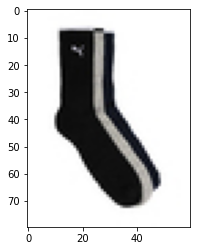

In [30]:
traindataset = TrainDataset(train)
file_names = train['id'].values
# file_path = f'./Data/BoolArt/train_image/{file_names[5]}.jpg'
image = np.array(Image.open(file_path).convert("RGB"))
plt.imshow(image) 

In [42]:
np.array(train.target)

array([0, 4, 3, ..., 0, 8, 4], dtype=int64)

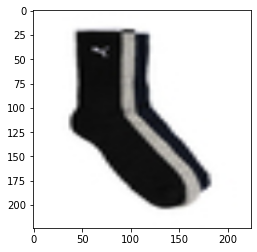

In [10]:
image = cv2.resize(image,(CFG.size_h,CFG.size_w))
plt.imshow(image)

In [11]:
# image

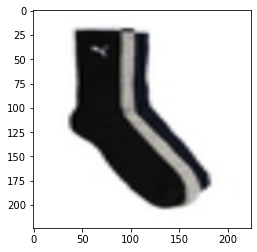

In [12]:
# 对图像做transform
transform_test = A.Compose([A.OpticalDistortion(p=0.3)])
transform_image = transform_test(image = image)["image"]
plt.imshow(transform_image)

## 定义模型

In [13]:
class CustomModel(nn.Module):
    def __init__(self,cfg,pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name,pretrained=pretrained,in_chans=3)
        
        #  print(self.model)
        if 'efficientnet' in self.cfg.model_name:
            self.n_features = self.model.classifier.in_features # 网络的输出分类1408
            self.model.global_pool = nn.Identity() 
            self.model.classifier = nn.Identity()
        elif 'resnet' in self.cfg.model_name:
            self.n_features = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
                            nn.Conv2d(self.n_features,44,1),
                        )
        def forward(self,x):
            bs = x.size(0) # 获取x的batch_size大小
            features = self.model(x)
            pool_feature = self.pooling(features)
            output = self.classifierfier(pool_feature).view(bs,-1)
            return output

In [14]:
net = timm.create_model('tf_efficientnet_b2')

In [15]:
net

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [16]:
net.get_classifier().in_features 

1408

In [17]:
net.classifier=nn.Conv2d(1480,44,1)

In [18]:
net

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [19]:
# ====================================================
# loader
# ====================================================
fold = 0
folds = train

# 0 折
trn_idx = folds[folds['fold'] != fold].index # 取出！=0  .index是返回dataframe的索引
val_idx = folds[folds['fold'] == fold].index # 取出折数=0的


train_folds = folds.loc[trn_idx].reset_index(drop=True) # reset_index(drop=True)为删除之前索引排序，从新开始索引
valid_folds = folds.loc[val_idx].reset_index(drop=True) 
valid_labels= valid_folds[CFG.target_col].values # label

train_dataset = TrainDataset(train_folds,transform=get_transforms(data='train'))
valid_dataset = TrainDataset(valid_folds,transform=get_transforms(data='valid'))

train_loader = DataLoader(train_dataset,
                         batch_size=CFG.batch_size,
                         shuffle=True,
                         num_workers=CFG.num_workers,
                         pin_memory=True,
                         drop_last=False)

valid_loader = DataLoader(valid_dataset,
                         batch_size=CFG.batch_size*2,
                         shuffle=False,
                         num_workers=CFG.num_workers,
                         pin_memory=True,
                         drop_last=False)

In [20]:
trn_idx

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            35539, 35540, 35541, 35542, 35543, 35544, 35546, 35548, 35549,
            35550],
           dtype='int64', length=28440)

In [21]:
valid_folds

,id,target,fold
0,15970,0,0
1,47359,2,0
2,7990,0,0
3,29742,2,0
4,3168,1,0
...,...,...,...
7106,42006,10,0
7107,51411,0,0
7108,4104,9,0
7109,12544,0,0


In [22]:
 folds[folds['fold']== fold]

,id,target,fold
0,15970,0,0
15,47359,2,0
22,7990,0,0
31,29742,2,0
37,3168,1,0
...,...,...,...
35513,42006,10,0
35519,51411,0,0
35522,4104,9,0
35545,12544,0,0


## 查看增强后图片效果

In [27]:
# def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
#     """绘制图像列表"""
#     figsize = (num_cols * scale, num_rows * scale)
#     _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
#     axes = axes.flatten()
#     for i, (ax, img) in enumerate(zip(axes, imgs)):
#         if torch.is_tensor(img):
#             # 图片张量
#             img = img.permute(1,2,0).numpy()*255
#             ax.imshow(img.astype(np.uint8))
#         else:
#             # PIL图片
#             ax.imshow(img)
#         ax.axes.get_xaxis().set_visible(False)
#         ax.axes.get_yaxis().set_visible(False)
#         ax.set_title(y[i].item())
#     return axes

# X, y = next(iter(train_loader))
# show_images(X, 8, 8, y);


## 定义训练和验证流程

In [24]:
# ====================================================
# train,valid
# ====================================================
def train_fn(train_loader,model,criterion,optimizer,epoch,scheduler,device):
    model.to(device)   
    # switch to train mode
    model.train()
    train_loss = []

    for batch in tqdm(dataloader):
        output = model(batchtch)

0         0
1         4
2         3
3         0
4         0
         ..
35546     1
35547    11
35548     0
35549     8
35550     4
Name: target, Length: 35551, dtype: int64